## Imports & Config

In [ ]:
!pip install -U --force-reinstall \
  transformers==4.38.2 \
  sentence-transformers==2.6.1


In [3]:
import transformers
import sentence_transformers
import numpy

print("transformers:", transformers.__version__)
print("sentence-transformers:", sentence_transformers.__version__)


transformers: 4.38.2
sentence-transformers: 2.6.1


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

RANDOM_STATE = 42
N_SPLITS = 5
print("imports complete")

imports complete


## Preprocessing

In [6]:
import re
import pandas as pd

def clean_text(text: str) -> str:
    text = str(text)  # safety
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\S+", "", text)
    text = re.sub(r"[^\x00-\x7F]+", "", text)
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()

df_train = pd.read_csv("training_data.csv")
df_test  = pd.read_csv("testing_data.csv")

X_train_text = df_train["text"].apply(clean_text).tolist()
y_train = df_train["label"].values

X_test_text = df_test["text"].apply(clean_text).tolist()
y_test = df_test["label"].values


## Encoder

In [7]:
encoder = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Cross-validated Eval

In [8]:
# def evaluate_model(clf, X_text, y):
#     skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

#     roc_scores, pr_scores, f1_scores = [], [], []

#     for train_idx, val_idx in skf.split(X_text, y):
#         X_tr = encoder.encode([X_text[i] for i in train_idx])
#         X_va = encoder.encode([X_text[i] for i in val_idx])

#         y_tr, y_va = y[train_idx], y[val_idx]

#         clf.fit(X_tr, y_tr)
#         probs = clf.predict_proba(X_va)[:, 1]

#         roc_scores.append(roc_auc_score(y_va, probs))
#         pr_scores.append(average_precision_score(y_va, probs))
#         f1_scores.append(f1_score(y_va, probs > 0.5))

#     return {
#         "ROC-AUC": np.mean(roc_scores),
#         "PR-AUC": np.mean(pr_scores),
#         "F1": np.mean(f1_scores),
#     }

'''Cache-embedded evaluation, faster by caching embeddings once with fast CV.
Code above runs 15 SVM trainings with 30 classifier fits, each with SBERT overhead.
Code above is leak-free version of evaluation though much slower. It also
allows SBERT to encode train and validation texts for each fold. This results in
20 SBERT encoding passes for 90K+ samples. Caching embeddings = 20 passes --> 1.'''

# Create encoder on GPU
encoder = SentenceTransformer(
    "all-MiniLM-L6-v2",
    device="cuda"
)

X_train_emb = encoder.encode(
    X_train_text,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

X_test_emb = encoder.encode(
    X_test_text,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

np.save("X_train_emb.npy", X_train_emb)
np.save("X_test_emb.npy", X_test_emb)

def evaluate_model_fast(clf, X_emb, y):
    skf = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=RANDOM_STATE
    )

    roc_scores = []

    for tr, va in skf.split(X_emb, y):
        clf.fit(X_emb[tr], y[tr])
        probs = clf.predict_proba(X_emb[va])[:, 1]
        roc_scores.append(roc_auc_score(y[va], probs))

    return np.mean(roc_scores)


Batches:   0%|          | 0/1444 [00:00<?, ?it/s]

Batches:   0%|          | 0/161 [00:00<?, ?it/s]

## Model Comparison

In [9]:
lr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

svm = CalibratedClassifierCV(
    LinearSVC(class_weight="balanced", random_state=RANDOM_STATE),
    method="sigmoid",
    cv=3
)

print("Logistic Regression:", evaluate_model_fast(lr, X_train_emb, y_train))
print("Calibrated SVM:", evaluate_model_fast(svm, X_train_emb, y_train))



Logistic Regression: 0.9719458557627672
Calibrated SVM: 0.9742684848344444


## Training & Test Eval

In [10]:
X_train_emb = np.load("X_train_emb.npy")
X_test_emb  = np.load("X_test_emb.npy")

svm = CalibratedClassifierCV(
    LinearSVC(class_weight="balanced", random_state=RANDOM_STATE),
    cv=2,
    method="sigmoid"
)

svm.fit(X_train_emb, y_train)

test_probs = svm.predict_proba(X_test_emb)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, test_probs))
print("Test PR-AUC:", average_precision_score(y_test, test_probs))
print(classification_report(y_test, test_probs > 0.5))

Test ROC-AUC: 0.972775311345572
Test PR-AUC: 0.9438971114738628
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      6773
           1       0.89      0.89      0.89      3494

    accuracy                           0.92     10267
   macro avg       0.91      0.91      0.91     10267
weighted avg       0.92      0.92      0.92     10267



## ROC & PR Curves

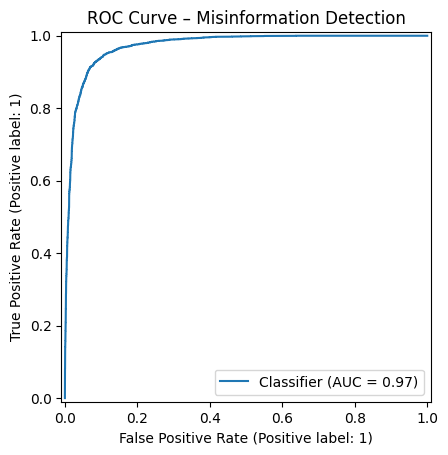

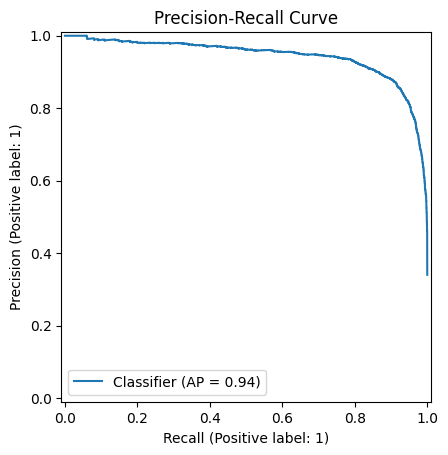

In [11]:
RocCurveDisplay.from_predictions(y_test, test_probs)
plt.title("ROC Curve – Misinformation Detection")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, test_probs)
plt.title("Precision-Recall Curve")
plt.show()


## Interactive Predictions

In [ ]:
def predict(tweet: str):
    txt = clean_text(tweet)
    emb = encoder.encode([txt])
    prob = svm.predict_proba(emb)[0, 1]
    return "MISINFO" if prob > 0.5 else "SAFE", prob